In [1]:
from __future__ import print_function, absolute_import, division
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ImageUtils import ImageUtils
import keras

D:\sf\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''常量'''
sourceFolder = 'D:/jupyter/car-management/api/rimages'
targetFolder = 'D:/jupyter/car-management/api/rimagesResize'
root = '.'
Xfilename = 'licenseplateL.npy'
Yfilename = 'label.npy'
filename = '字典.xlsx'

'''测试集'''
t_sourceFolder = 'D:/jupyter/car-management/api/test'
t_targetFolder = 'D:/jupyter/car-management/api/testim'
t_Xfilename = 't_licenseplateL.npy'
t_Yfilename = 't_label.npy'

In [3]:
'''数据处理工具类'''
utils = ImageUtils()

In [4]:
'''加载处理的数据'''
X_train_orig, Y_train_orig = utils.load(root, Xfilename, Yfilename)
X_train = (X_train_orig / 255).astype('float32')

Y_train = keras.utils.to_categorical(np.transpose(Y_train_orig), num_classes=66)

In [5]:
Y_label = []
for i in range(len(Y_train)):
    Y_label.append(Y_train[i])

x's shape: (1222, 320, 320, 3)
y's shape: (7, 1222, 66)
云MWG626
[18 53 62 47 37 33 37]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


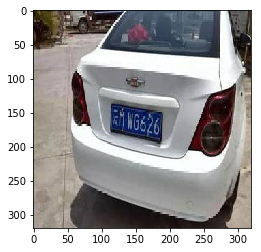

In [6]:
'''查看数据'''
print("x's shape: " + str(X_train.shape))
print("y's shape: " + str(Y_train.shape))
plt.imshow(X_train[23])
print(utils.getLabel(root, filename, Y_train_orig[23]))
# print(utils.getLabel(root, filename, np.argmax(Y_train[11], axis = -1)))
print(Y_train_orig[23])
print(Y_label[6][23])

In [7]:
'''define placeholder'''
def build_placeholder(input_shape = (None, 320, 320, 3), output_shape = (None, 66), outputs_num = 7, batch_size = 32, rep = 200):
    x = tf.placeholder(dtype = tf.float32, shape = input_shape)
    # save placeholders
    outputs = (x,)
    
    '''multiple y'''
    for i in range(outputs_num):
        y = tf.placeholder(dtype = tf.float32, shape = output_shape)
        outputs = outputs + (y,)
    
    dataset = tf.data.Dataset.from_tensor_slices(outputs)
    dataset = dataset.repeat(rep)
    dataset = dataset.shuffle(buffer_size=10000)
    # [Other transformations on `dataset`...]
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    return iterator, next_element, outputs

In [8]:
def build_inception(x, depth, first_layer_filters, second_layer_filters, base_name):
    
    with tf.name_scope(base_name + '_max_pool'):
        '''3 * 3 max pool'''
        x = tf.nn.max_pool(x, [1, 3, 3, 1], [1, 2, 2, 1], padding = 'SAME')
    
    with tf.name_scope(base_name + '_hidden1'):
        '''1 * 1 convolution'''
        inception_w1 = tf.Variable(tf.truncated_normal([1, 1, depth, first_layer_filters]), dtype = tf.float32)
        inception_b1 = tf.Variable(tf.zeros(shape = [first_layer_filters]))
        inception_x1 = tf.nn.conv2d(x, inception_w1, [1, 1, 1, 1], padding = 'SAME')
        inception_x1 = tf.nn.relu(inception_x1 + inception_b1)
        
    with tf.name_scope(base_name + '_hidden2'):
        '''1 * 1 convolution'''
        inception_b2 = tf.Variable(tf.zeros(shape = [first_layer_filters]))
        inception_w2 = tf.Variable(tf.truncated_normal([1, 1, depth, first_layer_filters]), dtype = tf.float32)
        inception_x2 = tf.nn.conv2d(x, inception_w2, [1, 1, 1, 1], padding = 'SAME')
        inception_x2 = tf.nn.relu(inception_x2 + inception_b2)
    
    with tf.name_scope(base_name + '_hidden3'):
        '''max pool 2d'''
        inception_pool_x1 = tf.nn.max_pool(x, [1, 3, 3, 1], strides = [1, 1, 1, 1], padding = 'SAME')
        inception_pool_x1 = tf.nn.relu(inception_pool_x1)
    
    with tf.name_scope(base_name + '_hidden4'):
        '''skip 1 * 1 conv'''
        skip_inception_conv_b1 = tf.Variable(tf.zeros(shape = [second_layer_filters]))
        skip_inception_conv_w1 = tf.Variable(tf.truncated_normal([1, 1, depth, second_layer_filters]), dtype = tf.float32)
        skip_inception_conv_x1 = tf.nn.conv2d(x, skip_inception_conv_w1, strides = [1, 1, 1, 1], padding = 'SAME')
        skip_inception_conv_x1 = tf.nn.relu(skip_inception_conv_x1 + skip_inception_conv_b1)
    
    with tf.name_scope(base_name + '_hidden5'):
        '''3 * 3 convolution'''
        inception_b3 = tf.Variable(tf.zeros(shape = [second_layer_filters]))
        inception_w3 = tf.Variable(tf.truncated_normal([3, 3, first_layer_filters, second_layer_filters]), dtype = tf.float32)
        inception_x3 = tf.nn.conv2d(inception_x1, inception_w3, [1, 1, 1, 1], padding = 'SAME')
        inception_x3 = tf.nn.relu(inception_x3 + inception_b3)
    
    with tf.name_scope(base_name + '_hidden6'):
        '''5 * 5 convolution'''
        inception_b4 = tf.Variable(tf.zeros(shape = [second_layer_filters]))
        inception_w4 = tf.Variable(tf.truncated_normal([5, 5, first_layer_filters, second_layer_filters]), dtype = tf.float32)
        inception_x4 = tf.nn.conv2d(inception_x2, inception_w4, strides = [1, 1, 1, 1], padding = 'SAME')
        inception_x4 = tf.nn.relu(inception_x4 + inception_b4)
    
    with tf.name_scope(base_name + '_hidden7'):
        '''1 * 1 convolution'''
        inception_b5 = tf.Variable(tf.zeros(shape = [first_layer_filters]))
        inception_w5 = tf.Variable(tf.truncated_normal([1, 1, depth, first_layer_filters]), dtype = tf.float32)
        inception_x5 = tf.nn.conv2d(inception_pool_x1, inception_w5, strides = [1, 1, 1, 1], padding = 'SAME')
        inception_x5 = tf.nn.relu(inception_x5 + inception_b5)
    
    with tf.name_scope(base_name + '_concatenate'):
        '''concatenate'''
        concat = tf.concat([skip_inception_conv_x1, inception_x3, inception_x4, inception_x5], axis = -1)
    
    return concat

In [34]:
'''test build_inception method'''
const = tf.random_normal(shape = [4, 4, 5, 5])
concat = build_inception(const, 5, 10, 20, base_name = 'test')
print(concat)

Tensor("concat_1:0", shape=(4, 2, 3, 70), dtype=float32)


In [9]:
def build_softmax_classification(x, depth, filters, onehot_length = 66):
    '''average pool'''
    average_pool = tf.nn.avg_pool(x, [1, 5, 5, 1], strides = [1, 3, 3, 1], padding = 'SAME')
    
    '''1 * 1 conv2d'''
    conv_b = tf.Variable(tf.zeros(shape = [filters]))
    conv_w = tf.Variable(tf.truncated_normal([1, 1, depth, filters]), dtype = tf.float32)
    conv_x = tf.nn.conv2d(average_pool, conv_w, [1, 1, 1, 1], padding = 'SAME')
    relu_x = tf.nn.relu(conv_x + conv_b)
    
    '''flatten layer'''
    flatten = tf.layers.flatten(relu_x)
    
    '''get ANN inputs length'''
    row = flatten.get_shape().as_list().pop()
    
    '''ANN layers'''
    ann_b = tf.Variable(tf.constant(1.0, shape = [onehot_length]))
    ann_w = tf.Variable(tf.truncated_normal([row, onehot_length]), dtype = tf.float32)
    ann_x = tf.matmul(flatten, ann_w) + ann_b
    
    '''softmax'''
    softmax_ann = tf.nn.softmax(ann_x)
    
    return softmax_ann
    

In [65]:
'''test build_softmax_classification method'''
const1 = tf.random_normal(shape = [4, 4, 5, 5])
softmax1 = build_softmax_classification(const1, 5, 10, 66)
print(softmax1)

Tensor("Softmax_15:0", shape=(4, 66), dtype=float32)


In [10]:
'''cal depth'''
def cal_shape(tensor):
    shape = tensor.get_shape().as_list()
    length = len(shape)
    return shape[length - 1:length][0]

In [57]:
'''test cal_shape'''
t = tf.random_uniform(shape = (4, 4, 5, 5))
t = tf.nn.local_response_normalization(t)
shape = cal_shape(t)
print(shape)

5


In [11]:
def build_graph(placeholders, depth = 120, increment = 0):

    '''output'''
    x, y1, y2, y3, y4, y5, y6, y7 = placeholders 
    
    '''append output'''
    outputs = []
    
    with tf.name_scope('prev_layer'):
        '''first layer'''
        prev_wsi1 = cal_shape(x)
        b1 = tf.Variable(tf.zeros(shape = [prev_wsi1 + increment]))
        w1 = tf.Variable(tf.truncated_normal([7, 7, prev_wsi1, prev_wsi1 + increment]), dtype = tf.float32)
        l1 = tf.nn.conv2d(x, w1, strides = [1, 2, 2, 1], padding = 'VALID')
        l1 = tf.nn.relu(l1 + b1)
    
        '''second layer'''
        l2 = tf.nn.max_pool(l1, [1, 3, 3, 1], [1, 2, 2, 1], padding = 'SAME')

        '''third layer'''
        l3 = tf.nn.local_response_normalization(l2)

        '''fourth layer'''
        prev_wsi4 = cal_shape(l3)
        b4 = tf.Variable(tf.zeros(shape = [prev_wsi4 + increment]))
        w4 = tf.Variable(tf.truncated_normal([1, 1, prev_wsi4, prev_wsi4 + increment]), dtype = tf.float32) 
        l4 = tf.nn.conv2d(l3, w4, [1, 1, 1, 1], padding = 'SAME')
        l4 = tf.nn.relu(l4 + b4)
    
        '''fifth layer'''
        prev_wsi5 = cal_shape(l4)
        b5 = tf.Variable(tf.zeros(shape = [prev_wsi5 + increment]))
        w5 = tf.Variable(tf.truncated_normal([3, 3, prev_wsi5, prev_wsi5 + increment]), dtype = tf.float32)
        l5 = tf.nn.conv2d(l4, w5, [1, 1, 1, 1], padding = 'SAME')
        l5 = tf.nn.relu(l5 + b5)
        
        '''sixth layer lcaol response normalization'''
        l6 = tf.nn.local_response_normalization(l5)
    
    '''first layer depth'''
    prev_wsi6 = cal_shape(l6)
    
    '''fist inception block '''
    with tf.name_scope('first_inception'):
        concat1 = build_inception(l6, prev_wsi6, prev_wsi6 + increment, prev_wsi6 + 2 * increment, base_name = 'first')
        relu_concat1 = tf.nn.relu(concat1)
        dropout1 = tf.nn.dropout(relu_concat1, keep_prob = 0.25)
    
    wsi1 = cal_shape(dropout1)
    
    with tf.name_scope('first_output'):
        '''first character output'''
        output1 = build_softmax_classification(dropout1, wsi1, depth)
        outputs.append(output1)
        
    with tf.name_scope('second_output'):
        '''first character output'''
        output2 = build_softmax_classification(dropout1, wsi1, depth)
        outputs.append(output2)
        
    
    '''second layer depth'''
    wsi2 = cal_shape(dropout1)
    
    '''second inception block'''
    with tf.name_scope('second_inception'):
        concat2 = build_inception(dropout1, wsi2, wsi2 + increment, wsi2 + 2 * increment, base_name = 'second')
        relu_concat2 = tf.nn.relu(concat2)
        dropout2 = tf.nn.dropout(relu_concat2, keep_prob = 0.25)
    
    '''second layer depth'''
    wsi3 = cal_shape(dropout2)
    
    
    with tf.name_scope('third_output'):
        '''second character output'''
        output3 = build_softmax_classification(dropout2, wsi3, depth)
        outputs.append(output3)
        
    with tf.name_scope('fourth_output'):
        '''fourth character output'''
        output4 = build_softmax_classification(dropout2, wsi3, depth)
        outputs.append(output4)
    
    '''third layer depth'''
    wsi4 = cal_shape(dropout2)
    
    with tf.name_scope('third_inception'):
        '''third inception block'''
        concat3 = build_inception(dropout2, wsi4, wsi4 + increment, wsi4 + 2 * increment, base_name = 'third')
        relu_concat3 = tf.nn.relu(concat3)
        dropout3 = tf.nn.dropout(relu_concat3, keep_prob = 0.25)
    
    '''second layer depth'''
    wsi5 = cal_shape(dropout3)
    
    with tf.name_scope('fifth_output'):
        '''fifth character output'''
        output5 = build_softmax_classification(dropout3, wsi5, depth)
        outputs.append(output5)
    
    with tf.name_scope('sixth_output'):
        '''sixth character output'''
        output6 = build_softmax_classification(dropout3, wsi5, depth)
        outputs.append(output6)
    
    with tf.name_scope('seventh_output'):
        '''seventh character output'''
        output7 = build_softmax_classification(dropout3, wsi5, depth)
        outputs.append(output7)
            
    return outputs

In [12]:
def loss_optimizer(Yplaceholders, outputs, output_num):
    with tf.name_scope('loss_optimizer'):
        '''define losses'''
        out_losses = []
        for i in range(output_num):
            loss = tf.losses.softmax_cross_entropy(onehot_labels = Yplaceholders[i], logits = outputs[i])
            out_losses.append(loss)
    
        '''define optimizers'''
        optimizers = []
        for j in range(output_num):
            optimizer = tf.train.AdamOptimizer().minimize(out_losses[j])
            optimizers.append(optimizer)
    return out_losses, optimizers

In [13]:
'''reset graph'''
tf.reset_default_graph()

'''get placeholder'''
input_shape = X_train.shape
output_shape = Y_label[0].shape
outs = build_placeholder((32, 320, 320, 3), (32, 66), 7, 32, 200)
iterator, iter_elements, placeholders = build_placeholder(input_shape = (32, 320, 320, 3), output_shape = (32, 66))
outputs = build_graph(iter_elements, depth = 1024)
out_losses, optimizers = loss_optimizer(iter_elements[1:], outputs, output_num = 7)

In [78]:
default_graph = tf.get_default_graph()
tf.summary.FileWriter('./inceptionlogs', default_graph)

In [14]:
'''calculate accuracy'''
def accuracy(predictions, targets):
    return 100 * np.sum(np.argmax(predictions, -1) == np.argmax(targets, axis = -1)) / predictions.shape[0]
    

In [71]:
accuracy(np.array([[1, 0, 0 ,0], [0, 0, 0, 1], [0, 0, 0, 1]]), [[1, 0, 0 ,0], [0, 0, 0, 3], [4, 5, 6, 7]])

100.0

In [15]:
'''train network'''
def train(X, Y, iterator, placeholders, outputs, out_losses, optimizers, num_steps = 200, batch_size = 32):
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print('Initialized')
        
        '''merge all elements to seession run'''
        merges = outputs + out_losses + optimizers
        
        values = [X]
        for j in range(len(Y)):
            values.append(Y[j])
        
        feed_dict = {}
        for k in range(len(placeholders)):
            feed_dict[placeholders[k]] = values[k]
        sess.run(iterator.initializer, feed_dict = feed_dict)
        
        for i in range(num_steps):
            '''100 steps print accuracy'''
            all_results = sess.run(merges)
            
            if i % 50 == 0:
                '''print result'''
                results_length = len(all_results)
                flag_1 = results_length // 3
                flag_2 = 2 * flag_1
                print('{} steps info:'.format(i))
                for k in range(flag_2):
                    if k < flag_1:
                        print('node {0} accuracy: {1}'.format(k, accuracy(all_results[k], values[k])))
                    elif k < flag_2:
                        print('node {0} losses: {1}'.format(k - flag_1, all_results[k]))


In [16]:
'''use small random dataset test model'''
X_random_dataset = np.random.randn(32, 320, 320, 3)

Y_random_dataset = []
for i in range(7):
    Y_random_dataset.append(keras.utils.to_categorical(np.random.randint(low = 1, high =65, size = 32), num_classes = 66))

In [ ]:
train(X_random_dataset, Y_random_dataset, iterator, placeholders, outputs, out_losses, optimizers, num_steps = 200)

Initialized
0 steps info:


D:\sf\conda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


node 0 accuracy: 0.0
node 1 accuracy: 3.125
node 2 accuracy: 9.375
node 3 accuracy: 0.0
node 4 accuracy: 3.125
node 5 accuracy: 3.125
node 6 accuracy: 0.0
node 0 losses: 4.215356826782227
node 1 losses: 4.215356826782227
node 2 losses: 4.215356826782227
node 3 losses: 4.215356826782227
node 4 losses: 4.152856826782227
node 5 losses: 4.215356826782227
node 6 losses: 4.152856826782227
50 steps info:
node 0 accuracy: 0.0
node 1 accuracy: 6.25
node 2 accuracy: 3.125
node 3 accuracy: 0.0
node 4 accuracy: 3.125
node 5 accuracy: 0.0
node 6 accuracy: 0.0
node 0 losses: 4.215356826782227
node 1 losses: 4.215356826782227
node 2 losses: 4.215356826782227
node 3 losses: 4.215356826782227
node 4 losses: 4.215356826782227
node 5 losses: 4.215356826782227
node 6 losses: 4.215356826782227
100 steps info:
node 0 accuracy: 0.0
node 1 accuracy: 6.25
node 2 accuracy: 3.125
node 3 accuracy: 0.0
node 4 accuracy: 3.125
node 5 accuracy: 3.125
node 6 accuracy: 3.125
node 0 losses: 4.215356826782227
node 1 loss

In [80]:
'''train network'''
def train(X, Y, placeholders, outputs, out_losses, optimizers, num_steps = 200, batch_size = 32):
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print('Initialized')
        
        '''merge all elements to seession run'''
        merges = outputs + out_losses + optimizers
        
        for i in range(num_steps):
            offset = (batch_size * i) % (X.shape[0] - batch_size)
            end = offset + batch_size
            
            feed_dict = {}
            values = [X[offset : end]]
            for j in range(len(Y)):
                values.append(Y[j][offset : end])
            for k in range(len(placeholders)):
                feed_dict[placeholders[k]] = values[k]
            all_results = sess.run(merges, feed_dict = feed_dict)
            
            '''100 steps print accuracy'''
            if i % 100 == 0:
                '''print result'''
                results_length = len(all_results)
                flag_1 = results_length // 3
                flag_2 = 2 * flag_1
                print('{} steps info:'.format(i))
                for k in range(flag_2):
                    if k < flag_1:
                        print('node {0} accuracy: {1}'.format(k, accuracy(all_results[k], values[k])))
                    elif k < flag_2:
                        print('node {0} losses: {1}'.format(k - flag_1, all_results[k]))


In [81]:
'''train'''
train(X_train, Y_label, iterator, placeholders, outputs, out_losses, optimizers, num_steps = 200, batch_size = 32)

Initialized
0 steps info:
node 0 accuracy: 0.0
node 1 accuracy: 12.5
node 2 accuracy: 3.125
node 3 accuracy: 0.0
node 4 accuracy: 0.0
node 5 accuracy: 0.0
node 6 accuracy: 6.25
node 0 losses: 4.215356826782227
node 1 losses: 4.215355396270752
node 2 losses: 4.184106826782227
node 3 losses: 4.184106826782227
node 4 losses: 4.215356826782227
node 5 losses: 4.215356826782227
node 6 losses: 4.152856826782227


D:\sf\conda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


100 steps info:
node 0 accuracy: 0.0
node 1 accuracy: 0.0
node 2 accuracy: 0.0
node 3 accuracy: 0.0
node 4 accuracy: 0.0
node 5 accuracy: 3.125
node 6 accuracy: 3.125
node 0 losses: 4.215356826782227
node 1 losses: 4.215356826782227
node 2 losses: 4.215356826782227
node 3 losses: 4.215356826782227
node 4 losses: 4.215356826782227
node 5 losses: 4.184106826782227
node 6 losses: 4.184106826782227


In [51]:
'''train network'''
def predict(X, placeholders, outputs):
    with tf.Session() as sess:
#         tf.global_variables_initializer().run()
        print('Initialized')
        
        '''merge all elements to seession run'''
        inputs = placeholders[0]
        
        
        feed_dict = {inputs : X}
        all_results = sess.run(outputs, feed_dict = feed_dict)
        for i in range(len(all_results)):
            print('{} output: {}'.format(i, all_results[i]))

In [82]:
def cal_parameters_size(k):
    var_num = 0
    for v in tf.all_variables():
        var_num += np.prod(v.get_shape().as_list())
    result = var_num  / np.power(1024, 3) * k
    return result, var_num

In [31]:
print(cal_parameters_size(32))

(3.335802435874939, 111930956.0)


In [83]:
input_x = X_train[1]
input_x = input_x.reshape((1,) + input_x.shape)
predict(input_x, placeholders, outputs)

Initialized
0 output: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1 output: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
2 output: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
3 output: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4 output: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.